In [6]:
import pandas as pd
import os
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from pandas.core.arrays.sparse.array import maybe_box_datetimelike
import json


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Preprocessing functions and pipeline creation



In [9]:
def preprocess_data(data):
  columns_to_drop = list(filter(lambda x:"TextInput" in x, data.columns))
  data = data.drop(columns=columns_to_drop)
  return data

def create_and_fit_pipeline(X,y, model):
  # define type of columns
  status_columns = list(filter(lambda x:"sta_" in x, X.columns))
  one_hot_columns = list(X.select_dtypes(include=['object']).columns.drop(status_columns))
  numeric_features = X.select_dtypes(include=['number']).columns

  # create each transformer
  status_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
                                ('label_encoder', OrdinalEncoder())
                                ])
  one_hot_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='constant', fill_value='NaN')),
                                ('one_hot_encoder', OneHotEncoder())
                                ])

  numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='mean')),
                                ])#('scaler',StandardScaler())

  # create preprocessor
  preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('one_hot_categorical', one_hot_transformer, one_hot_columns),
        ('status_categorical', status_transformer, status_columns)
    ]
  )

  # create pipeline
  pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',model)
  ])

  # fit pipeline
  pipeline.fit(X,y)

  return pipeline

def shap_feature_ranking(data, shap_values, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns

    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    # Assume we are in multiclass classification
    means = [(class_,np.abs(shap_values[class_][:, c_idxs]).mean(axis=0)) for class_ in range(len(shap_values))]  # Compute mean shap values per class

    shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes
    shap_means = shap_means[1]
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = {'feature':columns, 'mean_shap_value':shap_means}
    for class_, mean_value in means:
      df_ranking[f'class_{class_}'] = mean_value

    df_ranking = pd.DataFrame(df_ranking).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

In [ ]:
df_path = ''
file = ''

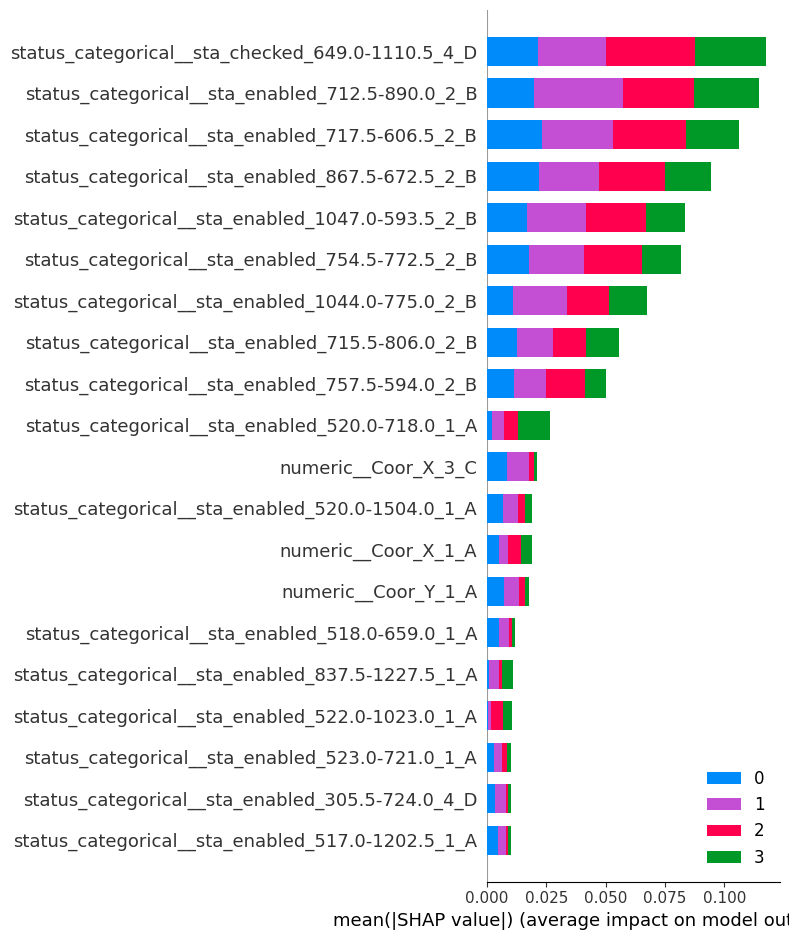

In [10]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# model = XGBClassifier()
model = RandomForestClassifier(n_estimators=100,random_state=1200)

# for f in os.listdir(df_path)[:4]:
data = pd.read_csv(df_path + "/" + file, index_col=0)
data = preprocess_data(data)
X = data.drop(columns=["Variant"])
y = data["Variant"]
y=y-1
# label_encoder_y = LabelEncoder() # TODO Controlar label con clase (puede que varíe)
# y = label_encoder_y.fit_transform(y)
# y = pd.Series(y)
# Create and fit pipeline
pipeline = create_and_fit_pipeline(X,y, model)

# get preprocessor and model
model = pipeline.named_steps["model"]
preprocessor = pipeline.named_steps["preprocessor"]
feature_name_out = preprocessor.get_feature_names_out()

# define explainer
explainer = shap.TreeExplainer(model)

X_processed = preprocessor.transform(X)
X_processed = pd.DataFrame(X_processed, columns=feature_name_out)

shap_values = explainer.shap_values(X_processed)

# Imprimir las contribuciones SHAP para una instancia de prueba

instance_index = 0
shap.summary_plot(shap_values, X_processed, feature_names=feature_name_out, class_inds='original', class_names=model.classes_)


# EXPLAINED TRACK

In [285]:
class ExplainedTrack():
  def __init__(self, shap_values, data, model, columns_name=None):
    self.data = data
    self.model = model
    if isinstance(shap_values, list): # several values for classification
      self.shap_values = np.array(shap_values)
      self.type_ = 'multiple'
    else:
      assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array'
      self.shap_values = shap_values
      self.type_ = 'binary'
    if columns_name is not None:
      self.columns_name = columns_name
    else:
      try:
        self.columns_name = model.feature_names_in_.tolist()
      except AttributeError:
        self.columns_name = data.columns.tolist()
      except Exception as e:
        print(f'Some error occurred during the assignment in the creation of the "columns_names" attribute. Please check the data or specifically provide the "columns_names" attribute.\n{e}')

  def get_global_shap_feature_ranking(self, shap_values=None):
      '''
      This method returns a pandas.DataFrame including:
      case binary classification:
        - "complete_feature_importance": the mean SHAP values of each feature
      case multiple classification:
        - "feature_importance_class{class_}": the mean SHAP values of feature for the class-specific (class_)
        - "complete_feature_importance": the sum of each class-specific importance
      '''

      columns = self.columns_name  # Get the names of the columns/features
      shap_values = self.shap_values if shap_values is None else shap_values  # Get the SHAP values
      indexes = []

      # Get the indexes of the columns in the data
      for column in columns:
          indexes.append(self.data.columns.get_loc(column))

      if self.type_ == 'multiple':
          # Calculate mean SHAP values for each class and feature
          means = [(class_, np.abs(shap_values[class_][:, indexes]).mean(axis=0)) for class_ in range(len(shap_values))]

          # Compute the sum of mean SHAP values for each feature across all classes
          shap_means = np.sum(np.column_stack(means), 1)
          shap_means = shap_means[1]  # Extract the mean SHAP values (excluding the baseline class)

          # Create a dataframe with feature, complete_feature_importance, and class-specific mean values
          df_ranking = {'feature': columns, 'complete_feature_importance': shap_means}
          for class_, mean_value in means:
              df_ranking[f'feature_importance_class_{class_}'] = mean_value

          # Sort the dataframe by complete_feature_importance in descending order and reset the index
          df_ranking = pd.DataFrame(df_ranking).sort_values(by='complete_feature_importance', ascending=False).reset_index(drop=True)
          df_ranking.index += 1  # Adjust the index to start from 1
      else:
          # Calculate mean SHAP values for each feature
          shap_means = np.abs(shap_values).mean(axis=0)

          # Create a dataframe with feature and complete_feature_importance
          df_ranking = pd.DataFrame({'feature': columns, 'complete_feature_importance': shap_means})

          # Sort the dataframe by complete_feature_importance in descending order and reset the index
          df_ranking = df_ranking.sort_values(by='complete_feature_importance', ascending=False).reset_index(drop=True)
          df_ranking.index += 1  # Adjust the index to start from 1

      return df_ranking

  def get_positive_shap_feature_ranking(self):
      '''
      Returns the SHAP feature ranking considering only features with a positive impact on the corresponding classification value.
      See "get_global_shap_feature_ranking".
      '''
      copy_shap_values = self.shap_values.copy()  # Create a copy of the SHAP values

      # Set negative SHAP values to zero, considering only positive impacts
      copy_shap_values[copy_shap_values < 0] = 0

      # Call the get_global_shap_feature_ranking method with the modified SHAP values
      return self.get_global_shap_feature_ranking(copy_shap_values)

  def get_indexed_weights(self, condition='positive'):
      '''
      This method returns:
      - case of binary classification:
        "feature_weights": a dictionary where each key is a feature, and the corresponding value is a pandas.Series.
        Each row in the Series represents the SHAP value and the index of a specific prediction from the data.

      - case of multiple classification:
        "feature_weights": a list of dictionaries, where each dictionary represents feature weights for a specific classification value.
        The keys in each dictionary are the features, and the values are pandas.Series representing the SHAP values and indices.

      The "condition" parameter determines whether to consider only positive SHAP values or all non-zero SHAP values.
      '''
      if self.type_ == 'multiple':
          feature_weights = []  # List to store dictionaries of feature weights for each classification value
          for shap_value_class in self.shap_values:
              shap_df_class_i = pd.DataFrame(shap_value_class, columns=self.columns_name)

              if condition == 'positive':
                  columns = shap_df_class_i[shap_df_class_i > 0]  # Select columns with positive SHAP values
              else:
                  columns = shap_df_class_i[shap_df_class_i != 0]  # Select columns with non-zero SHAP values

              feature_weights_class = {}  # Dictionary to store feature weights for the current classification value

              for f in self.columns_name:
                  column = columns[f].dropna()  # Drop NaN values from the column

                  if not list(column):
                      continue  # Skip if the column is empty (no SHAP values)

                  feature_weights_class[f] = column  # Store the column (feature weights) in the dictionary

              feature_weights.append(feature_weights_class)  # Append the dictionary to the list of feature weights
      else:
          feature_weights = {}  # Dictionary to store feature weights for binary classification
          shap_df = pd.DataFrame(self.shap_values, columns=self.columns_name)

          if condition == 'positive':
              columns = shap_df[shap_df > 0]  # Select columns with positive SHAP values
          else:
              columns = shap_df[shap_df != 0]  # Select columns with non-zero SHAP values

          for f in self.columns_name:
              column = columns[f].dropna()  # Drop NaN values from the column

              if not list(column):
                  continue  # Skip if the column is empty (no SHAP values)

              feature_weights[f] = column  # Store the column (feature weights) in the dictionary

      return feature_weights  # Return the dictionary/list of feature weights


  def get_feature_media_value(self):
      '''
      This method returns:
      - case of binary classification:
        "feature_media_value": a dictionary where each key is a feature label from the data, and the corresponding value is the mean value from the original data.

      - case of multiple classification:
        "feature_media_value": a list of dictionaries, where each dictionary represents feature mean values for a specific classification value.
      '''

      def get_feature_media_value_class(feature_media_value_class):
          # Calculate the mean value for each feature in the given dictionary
          for f in self.columns_name:
              if f in feature_media_value_class:
                  column = feature_media_value_class[f]
                  index = column.index.tolist()
                  media_value = self.get_media_value(f, index)  # Calculate the mean value for the feature based on the original data
              else:
                  media_value = None  # Set the mean value to None if the feature doesn't exist in the dictionary
              feature_media_value_class[f] = media_value  # Update the dictionary with the mean value
          return feature_media_value_class

      feature_media_value = self.get_indexed_weights()  # Get the feature weights

      if self.type_ == 'multiple':
          # Iterate over each dictionary in the list of feature weights
          for feature_media_value_class in feature_media_value:
              feature_media_value_class = get_feature_media_value_class(feature_media_value_class)  # Calculate the mean values for the features in the dictionary
      else:
          feature_media_value = get_feature_media_value_class(feature_media_value)  # Calculate the mean values for the features in the dictionary

      return feature_media_value  # Return the resulting dictionary/list of feature mean values


  def get_media_value(self, feature, indexes):
      '''
      This method calculates the mean value of a specific feature based on the original data using the given indexes.

      Inputs:
      - feature: The name/label of the feature.
      - indexes: The list of indexes corresponding to the feature weights.

      Returns:
      - The mean value of the feature based on the original data.
      '''

      return self.data[feature][indexes].mean()  # Calculate the mean value of the feature using the original data and the provided indexes

  def get_dataframe_media_value_importance(self, threshold=-1, order='individual', only_positive=False):
      '''
      This method returns a list of pandas.DataFrame (only one element for binary classification) where each DataFrame includes:
      - "Feature": the name of the feature.
      - "Media Value": The mean value obtained by using the get_media_value method.
      - "Importance": The importance value of the feature obtained using 'get_positive_shap_feature_ranking' if only_positive is True,
        or 'get_global_shap_feature_ranking' if only_positive is False.
        The value is obtained from the column "complete_feature_importance" if order is 'global',
        or from "feature_importance_class_{class_}" if order is 'individual'.
        Note that for binary classification, only order='individual' is supported.

      Inputs:
      - threshold: The minimum importance value to include a feature in the resulting DataFrame. Default is -1 (no threshold).
      - order: The order of importance. Can be 'individual' or 'global'. Default is 'individual'.
      - only_positive: Whether to consider only positive SHAP values for calculating feature importance. Default is False.

      Returns:
      - A list of pandas.DataFrame, where each DataFrame contains the feature, media value, and importance for the corresponding classification value.
      '''

      assert order == 'individual' or order == 'global', "Order should be equal to 'individual' or 'global'."
      result = []
      feature_media_value = self.get_feature_media_value()

      if self.type_ == 'binary':
          feature_media_value = list(feature_media_value)
          assert order == 'individual', "For binary classification, only 'individual' order is supported" #TODO revisar order default

      for i, feature_media_value_class in enumerate(feature_media_value):
          ranking = self.get_positive_shap_feature_ranking() if only_positive else self.get_global_shap_feature_ranking()

          if order == 'global':
              feature_importance = {key: value for key, value in zip(ranking['feature'], ranking['complete_feature_importance'])}
          elif order == 'individual':
              feature_importance = {key: value for key, value in zip(ranking['feature'], ranking[f'feature_importance_class_{i}'])}

          df = pd.DataFrame.from_dict(feature_media_value_class, orient='index', columns=['Media Value'])

          # Reset the index to make the keys a separate column
          df.reset_index(inplace=True)
          df.rename(columns={'index': 'Feature'}, inplace=True)

          df['Importance'] = df['Feature'].map(feature_importance)

          # Sort the dataframe by the 'Importance' column in descending order
          df.sort_values(by='Importance', ascending=False, inplace=True)

          # Reset the index
          df.reset_index(drop=True, inplace=True)

          sub_df = df[df['Importance'] > threshold]

          result.append(sub_df)

      return result

  def get_decision_path(self, threshold=-1, order='global', only_positive=False):
      '''
      This method generates a decision path dictionary, where each key represents a variant and the corresponding value is a nested dictionary
      representing the decision path for each classification value.

      Inputs:
      - threshold: The minimum importance value to include a feature in the decision path. Default is -1 (no threshold).
      - order: The order of importance. Can be 'individual' or 'global'. Default is 'global'.
      - only_positive: Whether to consider only positive SHAP values for calculating feature importance. Default is False.

      Returns:
      - A decision path dictionary representing the feature media values and importance values for each variant and classification value.
      '''

      result = {}  # Dictionary to store the decision path
      decision_dataframe_per_class = self.get_dataframe_media_value_importance(threshold=threshold, order=order, only_positive=only_positive)

      for i, df in enumerate(decision_dataframe_per_class):
          decision_per_class = df.to_dict('index')  # Convert the DataFrame to a nested dictionary (variant -> feature -> media value, importance)
          result[f'Variant_{i}'] = decision_per_class  # Assign the decision path for the current variant to the result dictionary # TODO revisar asignación de variante

      return result

def get_json_decision_path(self, threshold=-1, order='global', only_positive=False):
    '''
    This method generates a JSON representation of the decision path dictionary.

    Inputs:
    - threshold: The minimum importance value to include a feature in the decision path. Default is -1 (no threshold).
    - order: The order of importance. Can be 'individual' or 'global'. Default is 'global'.
    - only_positive: Whether to consider only positive SHAP values for calculating feature importance. Default is False.

    Returns:
    - A JSON string representing the decision path dictionary.
    '''

    decision_path = self.get_decision_path(threshold=threshold, order=order, only_positive=only_positive)  # Get the decision path dictionary
    return json.dumps(decision_path, indent=4)  # Convert the decision path dictionary to a formatted JSON string



In [286]:
explained_track = ExplainedTrack(shap_values, X_processed, model)

In [302]:
decision_global_all = explained_track.get_decision_path(threshold=0.1, order='global',only_positive=False)
print(json.dumps(decision_global_all['Variant_0'],indent=2))

{
  "0": {
    "Feature": "status_categorical__sta_checked_649.0-1110.5_4_D",
    "Media Value": 0.0,
    "Importance": 0.11743372840592212
  },
  "1": {
    "Feature": "status_categorical__sta_enabled_712.5-890.0_2_B",
    "Media Value": 1.0,
    "Importance": 0.11448446420271574
  },
  "2": {
    "Feature": "status_categorical__sta_enabled_717.5-606.5_2_B",
    "Media Value": 1.0,
    "Importance": 0.10602024712281669
  }
}


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [301]:
decision_global_positives = explained_track.get_decision_path(threshold=0.05,order='global',only_positive=True) # usually the threshold for the only_positive should be smaller
print(json.dumps(decision_global_positives['Variant_0'],indent=2))

{
  "0": {
    "Feature": "status_categorical__sta_checked_649.0-1110.5_4_D",
    "Media Value": 0.0,
    "Importance": 0.05871686420296106
  },
  "1": {
    "Feature": "status_categorical__sta_enabled_712.5-890.0_2_B",
    "Media Value": 1.0,
    "Importance": 0.05724223210135787
  },
  "2": {
    "Feature": "status_categorical__sta_enabled_717.5-606.5_2_B",
    "Media Value": 1.0,
    "Importance": 0.05301012356140834
  }
}


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [303]:
decision_individual_all = explained_track.get_decision_path(threshold=0.02, order='individual',only_positive=False) # usually the threshold of the individual should be smaller
print(json.dumps(decision_individual_all['Variant_0'],indent=2))

{
  "0": {
    "Feature": "status_categorical__sta_enabled_717.5-606.5_2_B",
    "Media Value": 1.0,
    "Importance": 0.023080492132821186
  },
  "1": {
    "Feature": "status_categorical__sta_enabled_867.5-672.5_2_B",
    "Media Value": 1.0,
    "Importance": 0.02177608632581503
  },
  "2": {
    "Feature": "status_categorical__sta_checked_649.0-1110.5_4_D",
    "Media Value": 0.0,
    "Importance": 0.02134697891491322
  }
}


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Here we observe a hard difference in the order beetween the first one 'decision_global_all'. Because know we are taking account the more relevants features for "Variant_0"

In [306]:
decision_individual_positives = explained_track.get_decision_path(threshold=0.01, order='individual',only_positive=True)
print(json.dumps(decision_individual_positives['Variant_0'],indent=2))

{
  "0": {
    "Feature": "status_categorical__sta_enabled_717.5-606.5_2_B",
    "Media Value": 1.0,
    "Importance": 0.01263862383187564
  },
  "1": {
    "Feature": "status_categorical__sta_checked_649.0-1110.5_4_D",
    "Media Value": 0.0,
    "Importance": 0.01111510652036538
  },
  "2": {
    "Feature": "status_categorical__sta_enabled_712.5-890.0_2_B",
    "Media Value": 1.0,
    "Importance": 0.010156625907332862
  }
}


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Here we observe a difference in the order with the previous one, because we are taking account only the data with positive impact to make the importance value.

## Global vision of media value importance

In [309]:
df_media_importance = explained_track.get_dataframe_media_value_importance(threshold=0.02)
df_media_importance

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[                                            Feature  Media Value  Importance
 0   status_categorical__sta_enabled_717.5-606.5_2_B          1.0    0.023080
 1   status_categorical__sta_enabled_867.5-672.5_2_B          1.0    0.021776
 2  status_categorical__sta_checked_649.0-1110.5_4_D          0.0    0.021347,
                                             Feature  Media Value  Importance
 0   status_categorical__sta_enabled_712.5-890.0_2_B          1.0    0.037470
 1   status_categorical__sta_enabled_717.5-606.5_2_B          1.0    0.029930
 2  status_categorical__sta_checked_649.0-1110.5_4_D          1.0    0.028980
 3   status_categorical__sta_enabled_867.5-672.5_2_B          1.0    0.025411
 4  status_categorical__sta_enabled_1047.0-593.5_2_B          1.0    0.024993
 5   status_categorical__sta_enabled_754.5-772.5_2_B          0.0    0.023130
 6  status_categorical__sta_enabled_1044.0-775.0_2_B          1.0    0.022699,
                                             Feature  Media Va

In [310]:
df_media_importance = explained_track.get_dataframe_media_value_importance(threshold=0.1, order='global')
df_media_importance

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[                                            Feature  Media Value  Importance
 0  status_categorical__sta_checked_649.0-1110.5_4_D          0.0    0.117434
 1   status_categorical__sta_enabled_712.5-890.0_2_B          1.0    0.114484
 2   status_categorical__sta_enabled_717.5-606.5_2_B          1.0    0.106020,
                                             Feature  Media Value  Importance
 0  status_categorical__sta_checked_649.0-1110.5_4_D          1.0    0.117434
 1   status_categorical__sta_enabled_712.5-890.0_2_B          1.0    0.114484
 2   status_categorical__sta_enabled_717.5-606.5_2_B          1.0    0.106020,
                                             Feature  Media Value  Importance
 0  status_categorical__sta_checked_649.0-1110.5_4_D          0.0    0.117434
 1   status_categorical__sta_enabled_712.5-890.0_2_B          0.0    0.114484
 2   status_categorical__sta_enabled_717.5-606.5_2_B          0.0    0.106020,
                                             Feature  Media V

Here is a clear example of the utility. Only with the 3 first labels, we have a clear difference to identify each variant.

## Others aspects of SHAP Estudio




Data extraction functions from shap_values



In [144]:
def get_positive_weights(shap_values, columns, class_, delete_empty=False):
  shap_df_class_i = pd.DataFrame(shap_values[class_],columns=columns)
  positives= shap_df_class_i[shap_df_class_i>0]
  # positives = shap_df_class_i.abs()
  feature_positive_weights = {}
  for f in feature_name_out:
    positive_column = positives[f].dropna()

    if delete_empty and not list(positive_column):
      continue
    feature_positive_weights[f] = positive_column

  return feature_positive_weights

def get_feature_importance(features_positive_weights):
  feature_importance = features_positive_weights.copy()
  for f in feature_importance:
    feature_importance[f] = feature_importance[f].mean()
  return feature_importance

def get_feature_media_value(data, feature_positive_weights):
  feature_media_value = feature_positive_weights.copy()
  for f in feature_media_value:
    positive_column = feature_media_value[f]
    positive_index = positive_column.index.tolist()
    media_value = get_media_value(data, f, positive_index)
    feature_media_value[f] = media_value
  return feature_media_value

def get_media_value(data, feature, indexes): # TODO hacer la media ponderada con el peso
  return data[feature][indexes].mean()

def get_dataframe_media_value_importance(feature_media_value,feature_importance):
  df = pd.DataFrame.from_dict(feature_media_value, orient='index', columns=['Media Value'])

  # Reset the index to make the keys a separate column
  df.reset_index(inplace=True)
  df.rename(columns={'index': 'Feature'}, inplace=True)
  df['Importance'] = df['Feature'].map(feature_importance)

  # Sort the dataframe by the 'Weight' column in descending order
  df.sort_values(by='Importance', ascending=False, inplace=True)

  # Reset the index
  df.reset_index(drop=True, inplace=True)

  return df



In [ ]:
#NOTAR QUE HAY DIFERENCIA CON LA VISUALIZACIÓN EN MODO BAR, PORQUE SÓLO SE HACE PARA LOS CASOS POSITIVOS
clase = 0
feature_positive_weights = get_positive_weights(shap_values.copy(), feature_name_out,clase, False)
feature_importance = get_feature_importance(feature_positive_weights)
feature_media_value = get_feature_media_value(X_processed, feature_positive_weights)

df = get_dataframe_media_value_importance(feature_media_value,feature_importance)
df
# positives.head()

,Feature,Media Value,Importance
0,status_categorical__sta_enabled_2175.0-840.0_1_A,1.0,0.035775
1,status_categorical__sta_enabled_717.5-606.5_2_B,1.0,0.025763
2,status_categorical__sta_enabled_1531.0-1369.0_1_A,1.0,0.022900
3,status_categorical__sta_checked_649.0-1110.5_4_D,0.0,0.022658
4,status_categorical__sta_enabled_712.5-890.0_2_B,1.0,0.020704
...,...,...,...
1536,status_categorical__sta_enabled_528.0-1393.5_1_A,NaN,NaN
1537,status_categorical__sta_enabled_1478.5-709.0_1_A,NaN,NaN
1538,status_categorical__sta_enabled_1305.0-1138.5_1_A,NaN,NaN
1539,status_categorical__sta_enabled_1368.5-1497.5_1_A,NaN,NaN


In [ ]:
def shap_feature_ranking(data, shap_values_real, columns=[]):
    if not columns: columns = data.columns.tolist()     # If columns are not given, take all columns
    shap_values = shap_values_real.copy()
    c_idxs = []
    for column in columns: c_idxs.append(data.columns.get_loc(column))  # Get column locations for desired columns in given dataframe
    if isinstance(shap_values, list):   # If shap values is a list of arrays (i.e., several classes)
        means = [np.abs(shap_values[class_][:, c_idxs]).mean(axis=0) for class_ in range(len(shap_values))]  # Compute mean shap values per class
        shap_means = np.sum(np.column_stack(means), 1)  # Sum of shap values over all classes
    else:                               # Else there is only one 2D array of shap values
        assert len(shap_values.shape) == 2, 'Expected two-dimensional shap values array.'
        shap_values[shap_values<0]=0
        shap_means = np.abs(shap_values).mean(axis=0)
        # shap_means = np.abs(shap_values[shap_values>0]).mean(axis=0)
        print(shap_means)
    # Put into dataframe along with columns and sort by shap_means, reset index to get ranking
    df_ranking = pd.DataFrame({'feature': columns, 'mean_shap_value': shap_means}).sort_values(by='mean_shap_value', ascending=False).reset_index(drop=True)
    df_ranking.index += 1
    return df_ranking

In [ ]:
feaure_ranking = shap_feature_ranking(X_processed, shap_values[clase])
feaure_ranking.head()

[0.         0.00209825 0.00332895 ... 0.         0.         0.        ]


,feature,mean_shap_value
1,status_categorical__sta_enabled_717.5-606.5_2_B,0.012639
2,status_categorical__sta_checked_649.0-1110.5_4_D,0.011115
3,status_categorical__sta_enabled_712.5-890.0_2_B,0.010157
4,status_categorical__sta_enabled_867.5-672.5_2_B,0.009276
5,status_categorical__sta_enabled_1047.0-593.5_2_B,0.008889


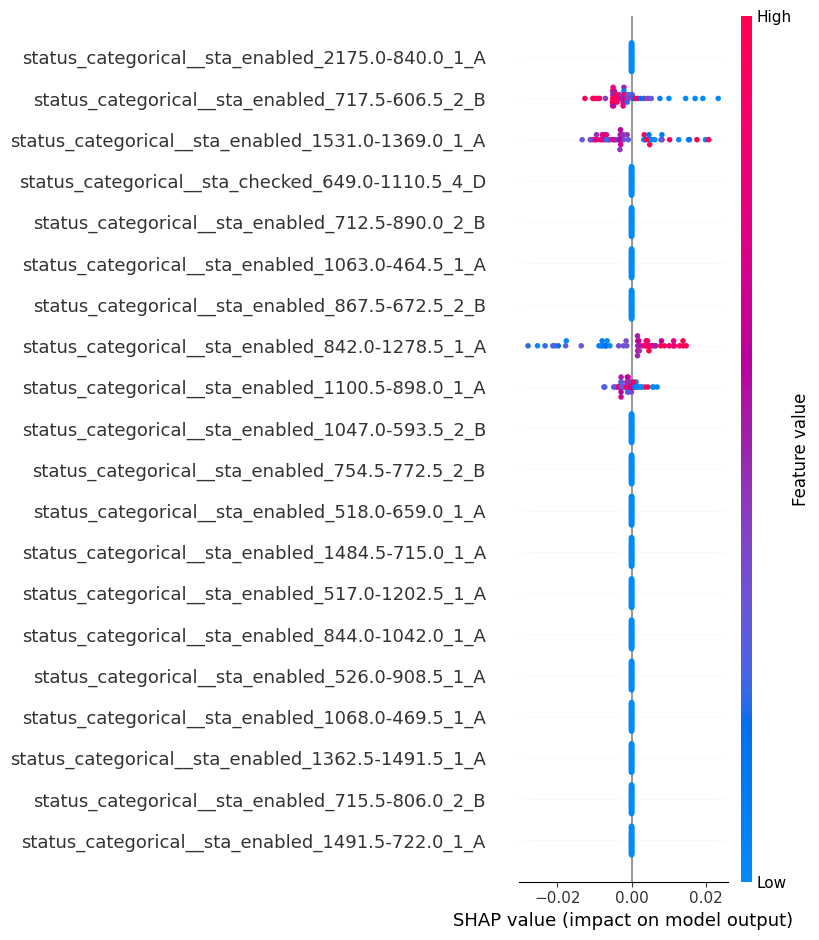

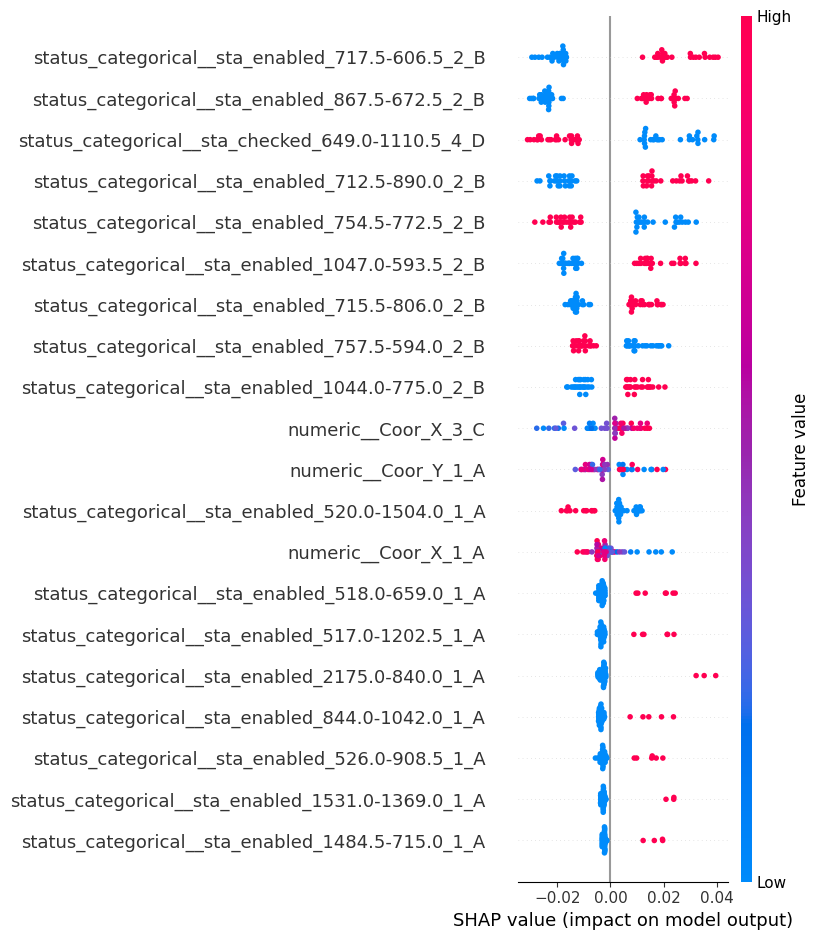

In [ ]:
feature_names = list(df['Feature'])
shap.summary_plot(shap_values[clase], X_processed, feature_names = feature_names, sort=False)
shap.summary_plot(shap_values[clase], X_processed)

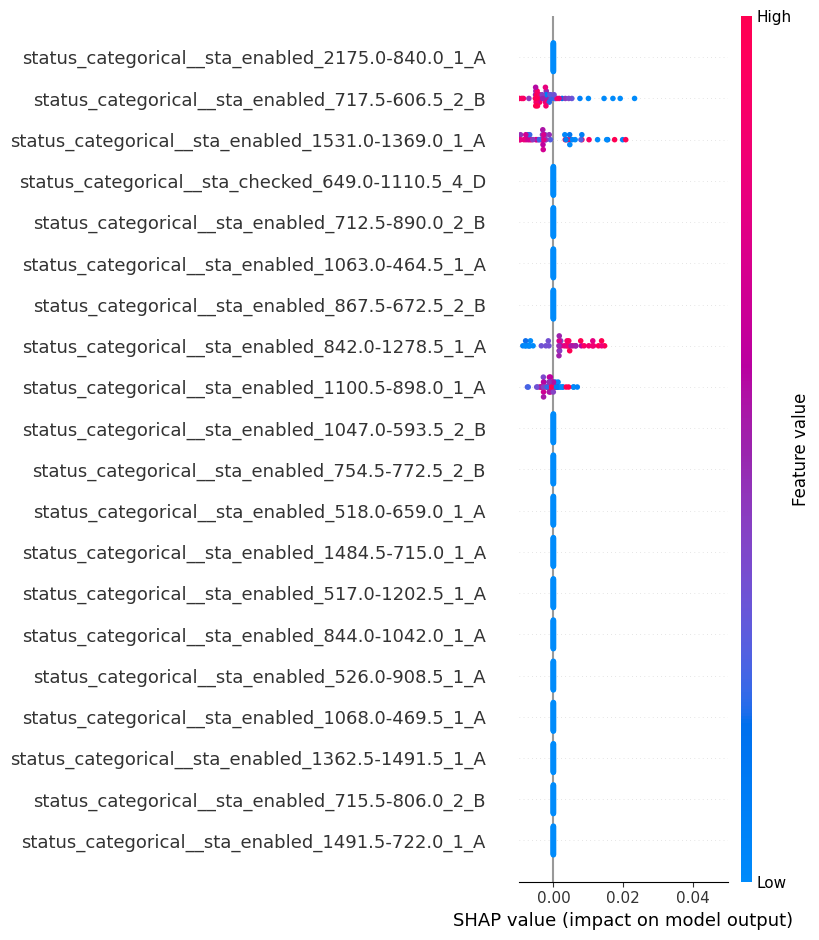

In [ ]:
import matplotlib.pyplot as plt
shap.initjs()
# Calculate shap_values
feature_names = list(df['Feature'])
shap.summary_plot(shap_values[clase], X_processed, feature_names = feature_names, sort=False,  show=False)
ax = plt.gca()

# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-0.01, 0.05)
plt.show()

In [ ]:
shap_df = pd.DataFrame(shap_values[clase],columns=feature_name_out)
feature_importance = (shap_df[shap_df>0].mean().sort_values(ascending=False).reset_index().rename(columns={'index':'feature',0:'weight'}))

feature_importance

,feature,weight
0,status_categorical__sta_enabled_2175.0-840.0_1_A,0.035775
1,status_categorical__sta_enabled_717.5-606.5_2_B,0.025763
2,status_categorical__sta_enabled_1531.0-1369.0_1_A,0.022900
3,status_categorical__sta_checked_649.0-1110.5_4_D,0.022658
4,status_categorical__sta_enabled_712.5-890.0_2_B,0.020704
...,...,...
1536,status_categorical__sta_enabled_528.0-1393.5_1_A,NaN
1537,status_categorical__sta_enabled_1478.5-709.0_1_A,NaN
1538,status_categorical__sta_enabled_1305.0-1138.5_1_A,NaN
1539,status_categorical__sta_enabled_1368.5-1497.5_1_A,NaN


In [ ]:
shap_df.head()

,numeric__MorKeyb_1_A,numeric__Coor_X_1_A,numeric__Coor_Y_1_A,numeric__Click_1_A,numeric__MorKeyb_2_B,numeric__Click_2_B,numeric__MorKeyb_3_C,numeric__Coor_X_3_C,numeric__Coor_Y_3_C,numeric__qua_button_1_A,...,status_categorical__sta_enabled_850.5-819.0_1_A,status_categorical__sta_enabled_838.0-1162.0_1_A,status_categorical__sta_enabled_514.0-538.0_1_A,status_categorical__sta_enabled_516.0-714.0_1_A,status_categorical__sta_enabled_532.0-1327.0_1_A,status_categorical__sta_enabled_528.0-1393.5_1_A,status_categorical__sta_enabled_1478.5-709.0_1_A,status_categorical__sta_enabled_1305.0-1138.5_1_A,status_categorical__sta_enabled_1368.5-1497.5_1_A,status_categorical__sta_enabled_584.0-572.0_2_B
0,0.0,-0.005112,-0.007254,0.0,0.0,0.0,0.0,-0.021160,-0.004545,0.0,...,0.000482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000380,-0.011083,0.0,0.0,0.0,0.0,-0.017533,-0.001198,0.0,...,0.000482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.005089,-0.004040,0.0,0.0,0.0,0.0,-0.013529,-0.007443,0.0,...,0.000098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.003434,0.020748,0.0,0.0,0.0,0.0,0.011302,0.000252,0.0,...,0.000482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.002134,0.008160,0.0,0.0,0.0,0.0,0.001590,0.000544,0.0,...,0.000125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clase 0:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


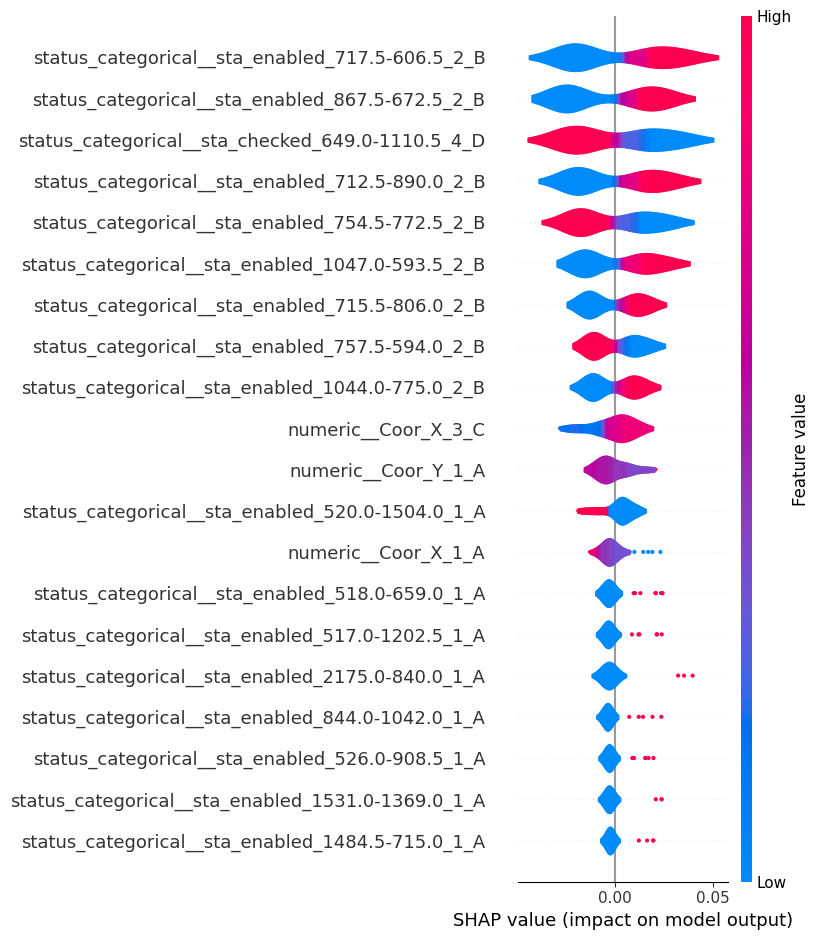

Clase 1:


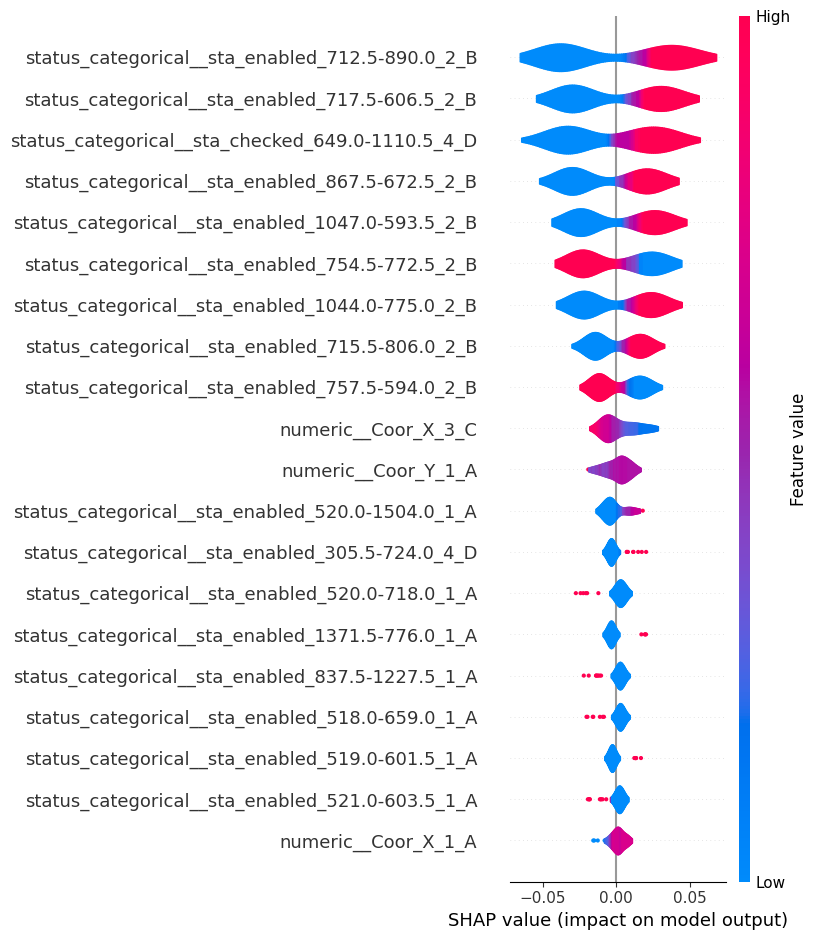

Clase 2:


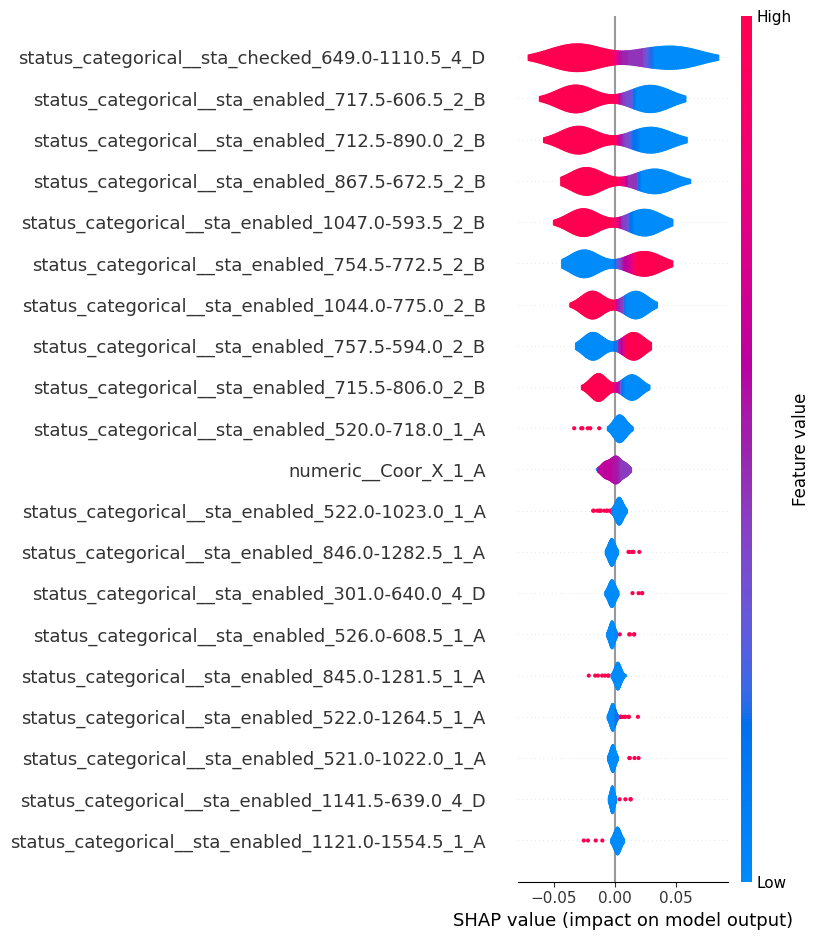

Clase 3:


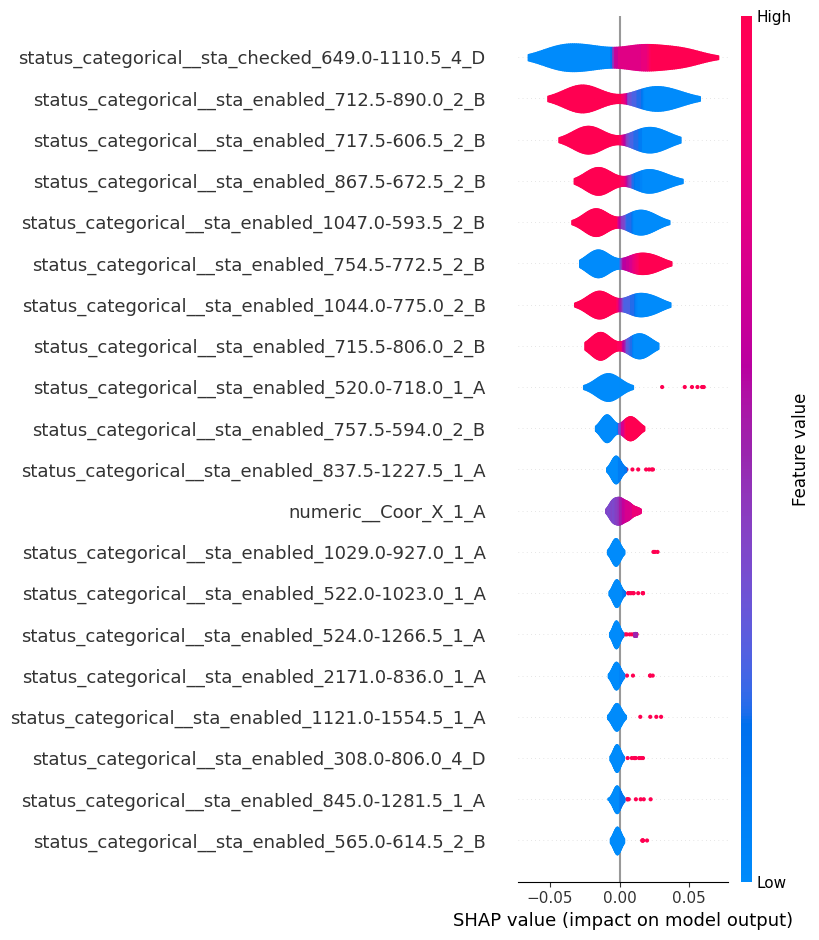

In [ ]:
# explainer_X = explainer(X_processed)
# print(type(explainer_X))
# print(type(explainer_X[100]))
for i in model.classes_:
  print(f'Clase {i}:')
  shap.summary_plot(shap_values[i], X_processed, feature_names=feature_name_out, plot_type="violin")
  # print(type(shap_values[i]))
  # shap.plots.beeswarm(explainer_X[i])

## Estudio de la feature importance


In [ ]:
shap_feature_importance = shap_feature_ranking(X_processed, shap_values)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
shap_feature_importance

,feature,mean_shap_value,class_0,class_1,class_2,class_3
1,status_categorical__sta_checked_649.0-1110.5_4_D,0.117434,0.021347,0.028980,0.037370,0.029737
2,status_categorical__sta_enabled_712.5-890.0_2_B,0.114484,0.019772,0.037470,0.029771,0.027471
3,status_categorical__sta_enabled_717.5-606.5_2_B,0.106020,0.023080,0.029930,0.030717,0.022293
4,status_categorical__sta_enabled_867.5-672.5_2_B,0.094375,0.021776,0.025411,0.027955,0.019232
5,status_categorical__sta_enabled_1047.0-593.5_2_B,0.083372,0.016693,0.024993,0.025148,0.016539
...,...,...,...,...,...,...
1537,status_categorical__sta_enabled_453.5-279.0_4_D,0.000000,0.000000,0.000000,0.000000,0.000000
1538,status_categorical__sta_enabled_227.5-108.0_4_D,0.000000,0.000000,0.000000,0.000000,0.000000
1539,status_categorical__sta_enabled_229.5-440.5_4_D,0.000000,0.000000,0.000000,0.000000,0.000000
1540,status_categorical__sta_enabled_162.5-2718.5_3_C,0.000000,0.000000,0.000000,0.000000,0.000000


##Estudio de la contribución de cada categoría

In [ ]:
expected_values = explainer.expected_value
print(f'The expected value for each class is: {expected_values}') #more close to 1 means more probability to be this class

The expected value for each class is: [0.20773585 0.28754717 0.27716981 0.22754717]


In [ ]:
predictions = pipeline.predict(X)

In [ ]:
predictions

array([1, 1, 1, 0, 3, 2, 0, 0, 0, 1, 3, 3, 3, 0, 0, 2, 3, 3, 3, 1, 2, 1,
       3, 2, 1, 1, 2, 1, 0, 3, 3, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 3, 1, 2,
       1, 2, 3, 2, 2, 0, 1, 2, 1])

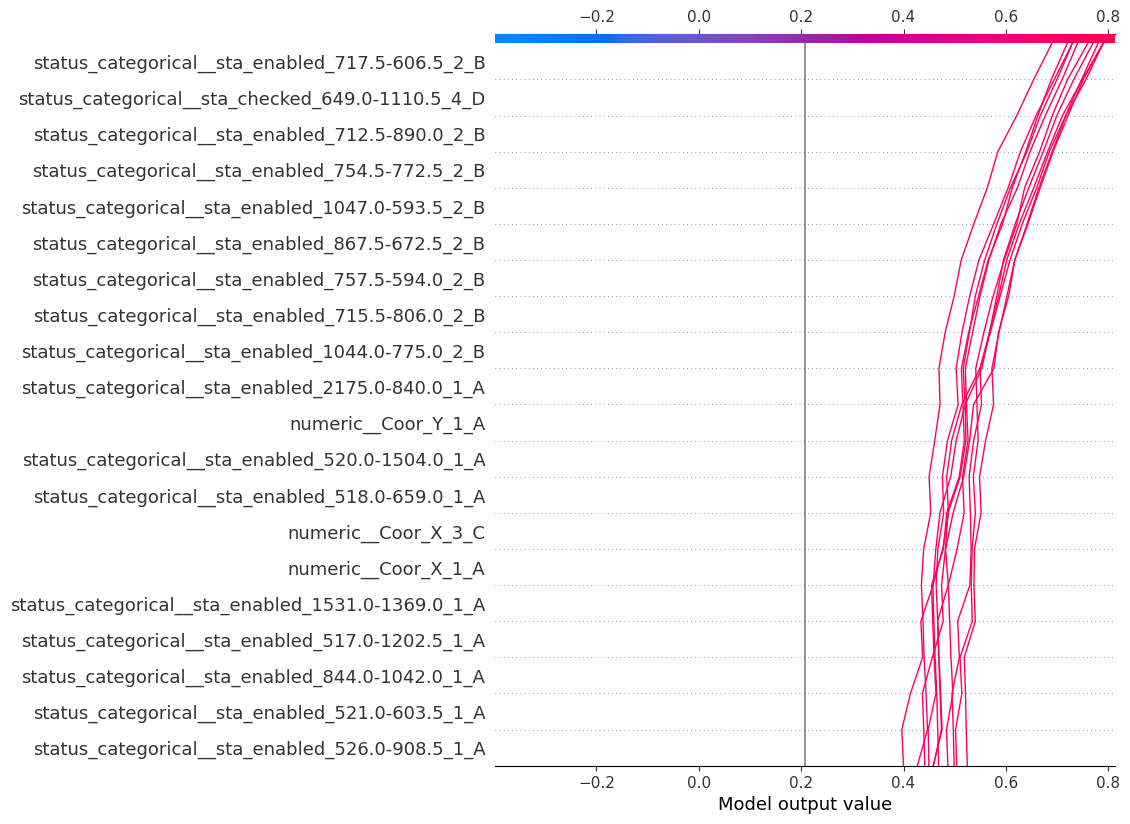

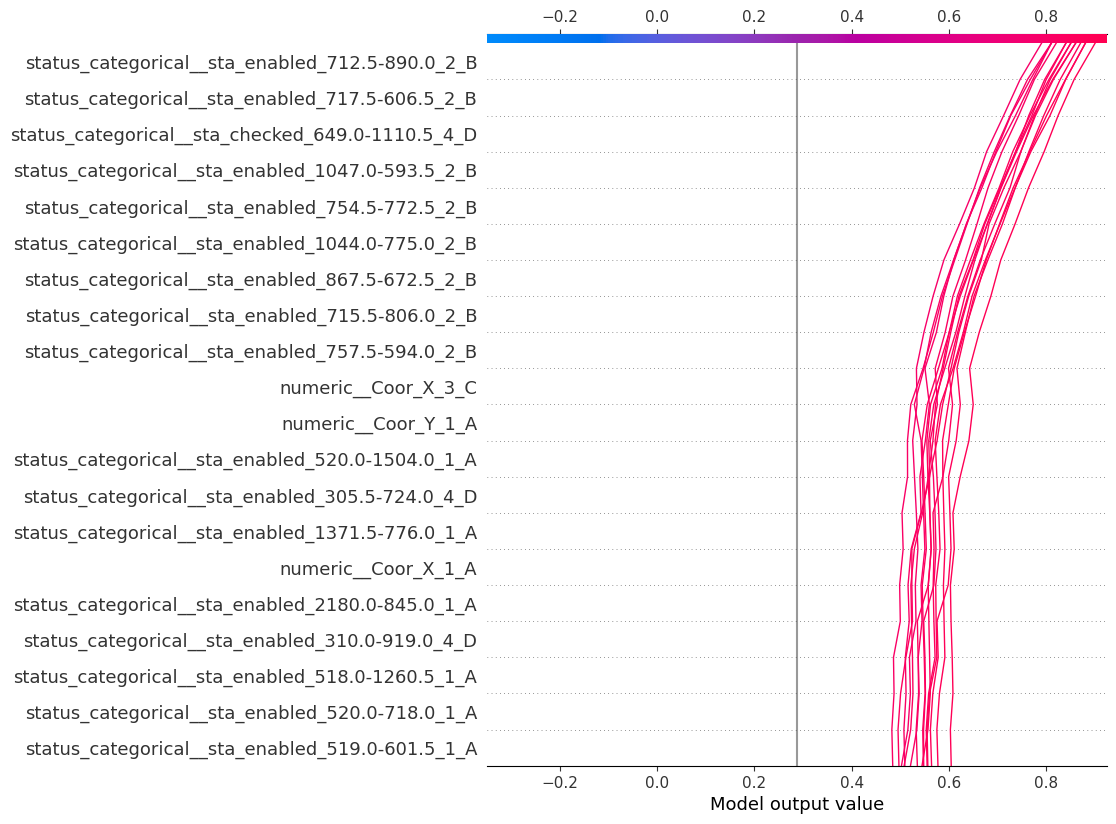

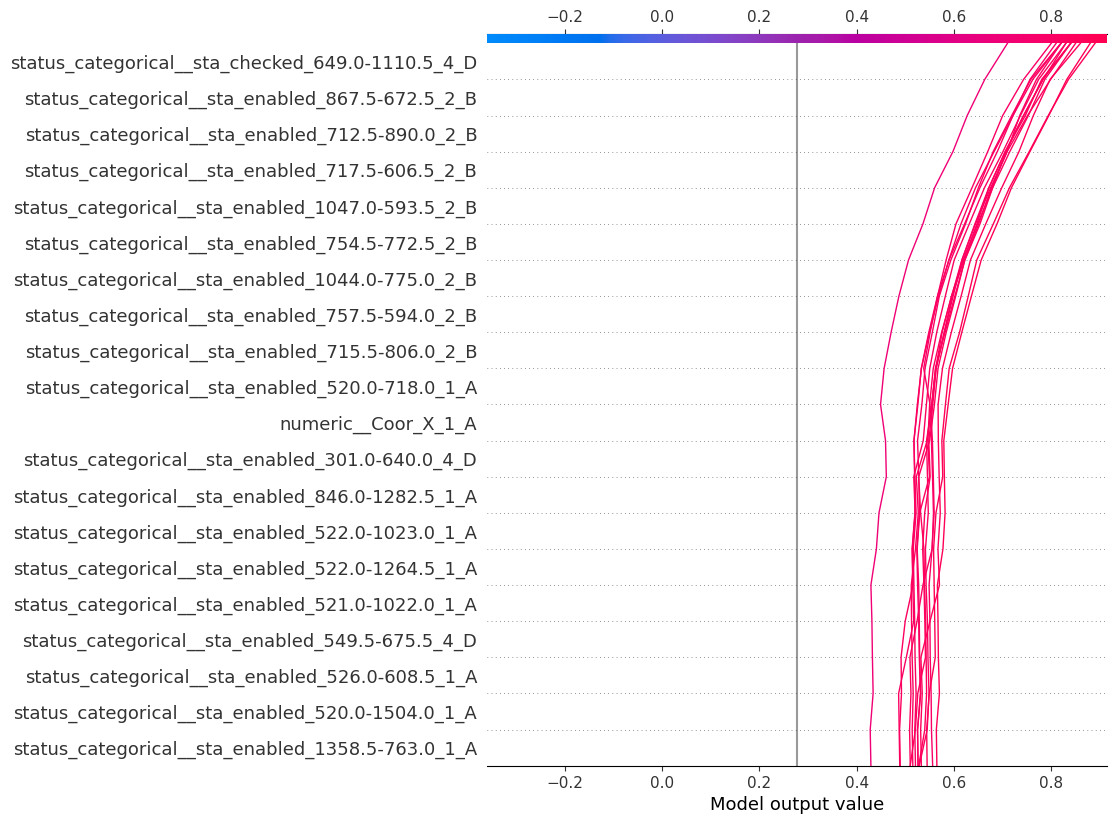

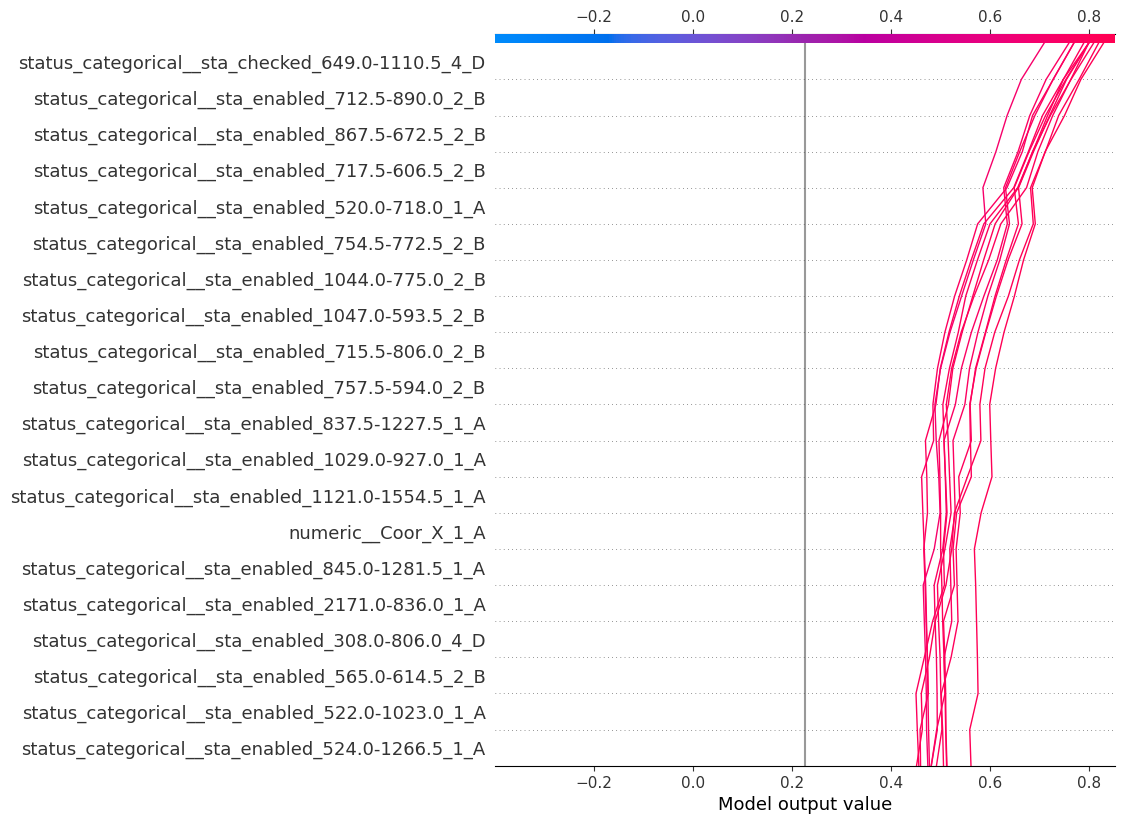

In [ ]:
# good classified decision_plot
# we see the contribution of each label
for i in range(4):
  index_classified_as_i = list(map(lambda x:x[0], filter(lambda x:x[1]==i, enumerate(predictions))))
  shap.decision_plot(expected_values[i], shap_values[i][index_classified_as_i], feature_names = feature_name_out)


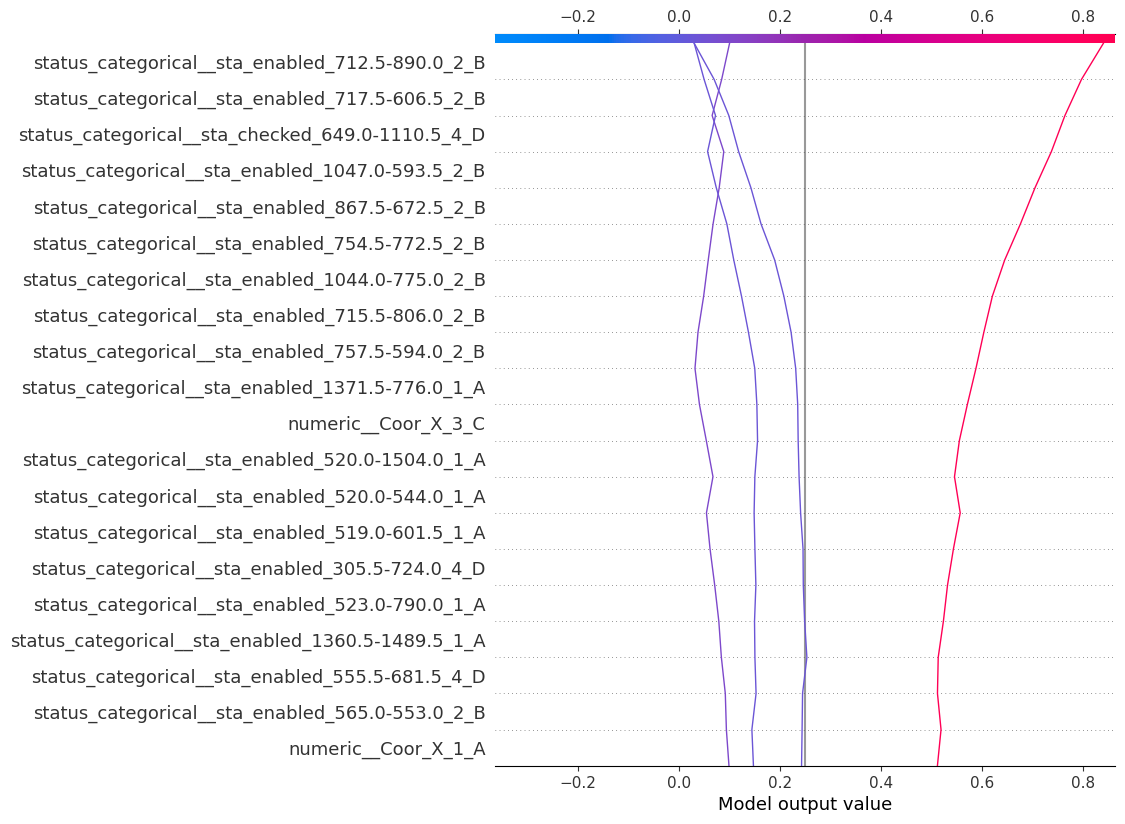

In [ ]:
shap.multioutput_decision_plot(expected_values, shap_values,2, feature_names = feature_name_out)

In [ ]:
expected_values = list(expected_values)
expected_values

[0.2077358490566038,
 0.28754716981132067,
 0.2771698113207547,
 0.2275471698113207]

In [ ]:
shap_values[0].shape

(53, 1541)

In [ ]:
X.shape

(53, 1544)